In [279]:
import pandas as pd
import numpy as np
import re # not really used atm
from datetime import datetime
from matplotlib import pyplot as plt
import seaborn as sns

In [280]:
from sklearn.preprocessing import StandardScaler # to scale data
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve,roc_auc_score,accuracy_score

# NN model
import keras
from keras.models import Sequential
from keras.models import load_model
from keras.layers import Dense
from keras.optimizers import SGD #test keras


In [281]:
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 60)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)

In [282]:
def check_null(df):
    print('\ncheck null values \n')
    print('shape df: ', df.shape, '\n')
    ok_columns = [col for col in df if df[col].isna().sum() == 0]
    print('ok columns: ', ok_columns, '\n')
    for col in df:
        if df[col].isna().sum() >0:
            print(col, ':', df[col].isna().sum())

In [283]:
df_original = pd.read_csv('../input/output_print_1683.csv')

In [284]:
# remove rows with NaN (originating e.g. from empty lines in input file)
df_original = df_original[df_original['flav'].notna()] 

In [285]:
# check_null(df)

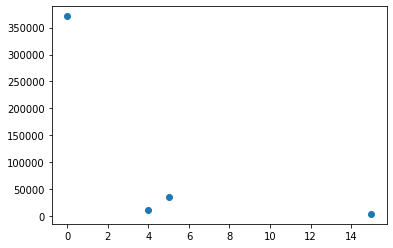

In [286]:
plt.scatter(df_original['flav'].value_counts().index, df_original['flav'].value_counts())

In [342]:
# do not consider PU jets
df = df_original[(df_original['truth_match']>0) & (df_original['quark_match']>0)]
#df = df_original[(df_original['ele_match']<1)]
# for the moment I want to focus on b-vs-light --> keep only real light and b, and put target to flav=5
df = df[(df['flav']==0) | (df['flav']==5) ]
df['target'] = (df['flav'] == 5 ).astype(int)

In [343]:
df[['truth_match','quark_match','ele_match']].describe()

,truth_match,quark_match,ele_match
count,94128.0,94128.0,94128.000000
mean,1.0,1.0,0.058272
std,0.0,0.0,0.234258
min,1.0,1.0,0.000000
25%,1.0,1.0,0.000000
50%,1.0,1.0,0.000000
75%,1.0,1.0,0.000000
max,1.0,1.0,1.000000


In [344]:
# check how many events and the fraction of b-jets
df['target'].describe()

count    94128.000000
mean     0.348122    
std      0.476377    
min      0.000000    
25%      0.000000    
50%      0.000000    
75%      1.000000    
max      1.000000    
Name: target, dtype: float64

In [345]:
df = df.replace([-999],[0])

In [346]:
# change the track pT into fraction of the jet_pt
# change time into time-t0 (if no t0, t0 is set to zero so no difference)
for i in range(25):
    col = 'pt_trk'+'_'+str(i)
    df[col] = df[col]/df['jet_pt']
    col = 'time'+'_'+str(i)
    df[col] = df[col]-df['t0']

In [347]:
df['avg_trk_time'] = (sum(df['time'+'_'+str(i)] for i in range(25)))/df['n_trk']

In [348]:
df[['time_1','time_2','time_3','avg_trk_time','t0']].head()

,time_1,time_2,time_3,avg_trk_time,t0
3,-0.204841,0.000667,0.000000,-0.032305,0.000000
4,0.000000,0.036975,-0.144176,-0.022542,0.000000
11,-0.005177,0.003688,0.329567,0.385841,-0.094547
12,-0.045804,0.094547,-0.025398,0.140651,-0.094547
13,-0.187377,0.095037,-0.075381,0.317621,-0.094547


In [349]:
for i in range(25):
    df.loc[df['has_t0']<1,'time'+'_'+str(i)] = df['time'+'_'+str(i)] - df['avg_trk_time']

In [350]:
df['n_trk'].describe()

count    94128.000000
mean     7.251509    
std      3.244954    
min      0.000000    
25%      5.000000    
50%      7.000000    
75%      9.000000    
max      26.000000   
Name: n_trk, dtype: float64

In [291]:
df[['flav']+['pt_trk'+'_'+str(i) for i in range(9)]].head()
# pfff, these are not pt ordered :( Probably pt-ordeered before calibration

,flav,pt_trk_0,pt_trk_1,pt_trk_2,pt_trk_3,pt_trk_4,pt_trk_5,pt_trk_6,pt_trk_7,pt_trk_8
0,0.0,0.212636,0.071751,0.134188,0.057887,0.043483,0.089078,0.309301,0.055388,0.042781
2,0.0,0.049948,0.067440,0.050830,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,5.0,0.084658,0.066121,0.058145,0.048145,0.043123,0.029888,0.025749,0.027303,0.023860
4,0.0,0.099132,0.170848,0.093001,0.028576,0.059057,0.038806,0.000000,0.000000,0.000000
5,0.0,0.030321,0.126199,0.006783,0.010370,0.033819,0.011501,0.027151,0.028721,0.048440


In [292]:
# useful to make list of column names
trk_info = ["ValZ0","SigZ0","ValD0","SigZ0","IP3D_trk_pb","IP3D_trk_pu","IP3D_trk_pc","pt_trk","has_time","time","nhits","has_time_truth","time_truth","nhits_truth"]

string=''
for i in range(25):
    for info in trk_info:
        string+=info+'_'+str(i)+', '

# print(string)

In [293]:
columns_to_use = []
trk_info_to_keep = ["IP3D_trk_pb","IP3D_trk_pu", "has_time","time","nhits"]
for i in range(20):
    for info in trk_info_to_keep:
        columns_to_use.append(info+'_'+str(i))

In [294]:
columns_to_use_df = columns_to_use[:]
columns_to_use_df += ['target','has_t0','t0']
df_to_use = df[columns_to_use_df]

In [296]:
#columns_to_use.remove('target')
# columns_to_use

In [297]:
# convert df into arrays
X = df_to_use[columns_to_use+['has_t0','t0']].values
y = df_to_use['target'].values
# scaling
sc = StandardScaler()
X = sc.fit_transform(X) 

In [298]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.3)

In [299]:
# Neural network
model = Sequential() # creating model sequentially (each layer takes as input output of previous layer)
model.add(Dense(100, input_dim=len(columns_to_use)+2, activation='relu')) # Dense: fully connected layer
# model.add(Dense(50, activation='relu'))
# model.add(Dense(20, activation='relu')) 
model.add(Dense(1, activation='sigmoid')) # chiara: check what's the best activation function for single-value output
# loss function and optimizer
#opt = SGD(lr=0.001)
#model.compile(loss = "binary_crossentropy", optimizer = opt, metrics=['accuracy'])
#model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
# training 
history = model.fit(X_train, y_train, epochs=10, batch_size=50, # it was 100 epochs
                    validation_data = (X_test,y_test)) # show accuracy on test data after every epoch

Train on 275026 samples, validate on 117869 samples
Epoch 1/10
275026/275026 [==============================] - 16s 60us/step - loss: 0.1522 - acc: 0.9506 - val_loss: 0.1405 - val_acc: 0.9550
Epoch 2/10
275026/275026 [==============================] - 17s 63us/step - loss: 0.1374 - acc: 0.9547 - val_loss: 0.1375 - val_acc: 0.9550
Epoch 3/10
275026/275026 [==============================] - 18s 65us/step - loss: 0.1341 - acc: 0.9559 - val_loss: 0.1375 - val_acc: 0.9551
Epoch 4/10
275026/275026 [==============================] - 18s 67us/step - loss: 0.1322 - acc: 0.9568 - val_loss: 0.1375 - val_acc: 0.9554
Epoch 5/10
275026/275026 [==============================] - 18s 64us/step - loss: 0.1309 - acc: 0.9570 - val_loss: 0.1345 - val_acc: 0.9564
Epoch 6/10
275026/275026 [==============================] - 17s 63us/step - loss: 0.1298 - acc: 0.9573 - val_loss: 0.1350 - val_acc: 0.9563
Epoch 7/10
275026/275026 [==============================] - 18s 64us/step - loss: 0.1286 - acc: 0.9575 - val

In [300]:
# Prediction
y_pred_test = model.predict(X_test)
y_pred_train = model.predict(X_train)

fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_pred_test)
fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_pred_train)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.


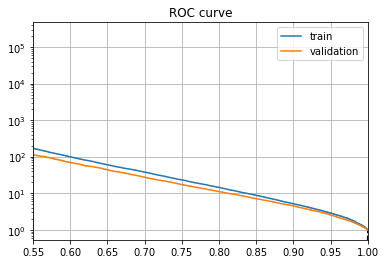

In [301]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(tpr_train, 1./fpr_train, label='train')
plt.plot(tpr_test, 1./fpr_test, label='validation')
#plt.xlabel('False positive rate')
#plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.yscale('log')
plt.xlim(0.55,1)
plt.grid(True)
plt.show()

In [302]:
X_train

array([[-2.23182585, -2.54536156, -1.57288424, ..., -0.01807064,
         1.91239669, -3.08344774],
       [ 0.12999899,  0.44530307,  0.6357747 , ..., -0.01807064,
        -0.66822898, -0.00815911],
       [-2.23182585, -2.54536156, -1.57288424, ..., -0.01807064,
         1.91239669, -0.13190752],
       ...,
       [-0.76592322,  1.14962514,  0.6357747 , ..., -0.01807064,
         1.91239669, -0.7545909 ],
       [ 0.22353927,  0.0827645 ,  0.6357747 , ..., -0.01807064,
        -0.66822898, -0.00815911],
       [ 0.24217178, -0.03155913,  0.6357747 , ..., -0.01807064,
        -0.66822898, -0.00815911]])

In [303]:
type(X_train)

numpy.ndarray

In [304]:
X_train.shape

(275026, 102)

In [305]:
test = range(45)

In [306]:
test2 = [i for i in test if i % 5 < 2]

In [307]:
X_train_no_HGTD = X_train[:,test2]
X_test_no_HGTD = X_test[:,test2]

In [308]:
X_train_no_HGTD.shape

(275026, 18)

In [309]:
# Neural network
model2 = Sequential() # creating model sequentially (each layer takes as input output of previous layer)
model2.add(Dense(100, input_dim=len(test2), activation='relu')) # Dense: fully connected layer
# model.add(Dense(50, activation='relu'))
# model.add(Dense(20, activation='relu')) 
model2.add(Dense(1, activation='sigmoid')) # chiara: check what's the best activation function for single-value output
# loss function and optimizer
#opt = SGD(lr=0.001)
#model.compile(loss = "binary_crossentropy", optimizer = opt, metrics=['accuracy'])
#model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
# training 
history = model2.fit(X_train_no_HGTD, y_train, epochs=10, batch_size=50, # it was 100 epochs
                    validation_data = (X_test_no_HGTD,y_test)) # show accuracy on test data after every epoch

Train on 275026 samples, validate on 117869 samples
Epoch 1/10
275026/275026 [==============================] - 10s 35us/step - loss: 0.1470 - acc: 0.9522 - val_loss: 0.1391 - val_acc: 0.9546
Epoch 2/10
275026/275026 [==============================] - 9s 33us/step - loss: 0.1378 - acc: 0.9549 - val_loss: 0.1369 - val_acc: 0.9554
Epoch 3/10
275026/275026 [==============================] - 9s 34us/step - loss: 0.1368 - acc: 0.9551 - val_loss: 0.1375 - val_acc: 0.9555
Epoch 4/10
275026/275026 [==============================] - 10s 36us/step - loss: 0.1361 - acc: 0.9553 - val_loss: 0.1360 - val_acc: 0.9554
Epoch 5/10
275026/275026 [==============================] - 10s 35us/step - loss: 0.1355 - acc: 0.9555 - val_loss: 0.1388 - val_acc: 0.9549
Epoch 6/10
275026/275026 [==============================] - 9s 33us/step - loss: 0.1352 - acc: 0.9555 - val_loss: 0.1345 - val_acc: 0.9562
Epoch 7/10
275026/275026 [==============================] - 9s 34us/step - loss: 0.1347 - acc: 0.9558 - val_los

In [310]:
# Prediction
y_pred_test_no_HGTD = model2.predict(X_test_no_HGTD)
y_pred_train_no_HGTD = model2.predict(X_train_no_HGTD)

fpr_test_no_HGTD, tpr_test_no_HGTD, thresholds_test_no_HGTD = roc_curve(y_test, y_pred_test_no_HGTD)
fpr_train_no_HGTD, tpr_train_no_HGTD, thresholds_train_no_HGTD = roc_curve(y_train, y_pred_train_no_HGTD)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  


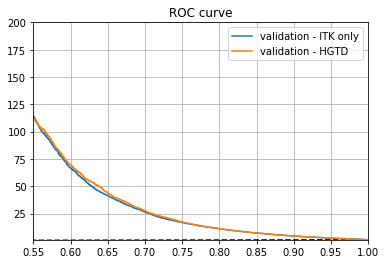

In [311]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
#plt.plot(tpr_train_no_HGTD, 1./fpr_train_no_HGTD, label='train_no_HGTD')
plt.plot(tpr_test_no_HGTD, 1./fpr_test_no_HGTD, label='validation - ITK only')
#plt.plot(tpr_train, 1./fpr_train, label='train')
plt.plot(tpr_test, 1./fpr_test, label='validation - HGTD')
#plt.xlabel('False positive rate')
#plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
#plt.yscale('log')
plt.xlim(0.55,1)
plt.ylim(1,200)
plt.grid(True)
plt.show()